In [1]:
'''
We use and edit the original code from https://github.com/paraklas/NARGP
'''

'\nWe use and edit the original code from https://github.com/paraklas/NARGP\n'

In [2]:
#!pip install GPy
import GPy
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as ml
import matplotlib.patches as mpatches
import numpy.matlib

In [3]:
# select expander protocol
idx_prcl = 0
protocols = ['AnteFace30x60mm38cc','AnteScalp50x130mm243cc','Forehead30x60mm38cc',\
            'LeftClav50x100mm133cc','LowerFace30x60mm38cc','PostScalp60x120mm221cc']
protocol = protocols[idx_prcl]

In [4]:
dim = 3 # input dataset dimension
##### traing input dataset
Nts = 400

set_tpts = [np.array([0,7,21,35,42,49,56,63,70,77,84,91,98,105]),\
            np.array([0,7,21,35,42,49,56,63,70,77,84,91,98,105]),\
            np.array([0,7,21,35,42,49,56,63,70,77,84,91,98,105]),\
            np.array([0,7,14,21,28,35,42,49,56,70,91,105]),\
            np.array([0,7,14,21,28,35,42,49,56,63,70,105]),\
            np.array([0,7,21,35,42,49,56,63,70,77,84,91,98,105])]

tpts = set_tpts[idx_prcl]

n_tpts = np.array([14,14,14,12,12,14])

if idx_prcl == 3 or idx_prcl == 4:
    idx_low = np.array([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,406,412,418,424,432,439])
    idx_low = np.array([0,10,20,30,40,50,60,70,80,90,100,\
                        110,120,130,140,150,160,170,180,190,200,\
                        210,220,230,240,250,260,270,280,290,300,\
                        310,320,330,340,350,360,370,380,390,400,\
                        410,420,430,439])
else:
    idx_low = np.array([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500,519])
    idx_low = np.array([0,10,20,30,40,50,60,70,80,90,100,\
                        110,120,130,140,150,160,170,180,190,200,\
                        210,220,230,240,250,260,270,280,290,300,\
                        310,320,330,340,350,360,370,380,390,400,\
                        410,420,430,440,450,460,470,480,490,500,510,519])
    
tpts_LF = np.loadtxt('LowFidelityModel/time_vec_%s.txt'%protocol)[idx_low]
tpts_HF = tpts

'''Training input dataset of low fidelity'''
training_data1 = np.loadtxt('LowFidelityModel/growth_low_fidelity_200T.txt')[50:,:]
xdim1,ydim1 = np.shape(training_data1)
num_time1 = np.shape(tpts_LF)[0]
X1 = np.zeros((xdim1*num_time1,ydim1+1))
for ii in range(xdim1):
    X1[num_time1*ii:num_time1*(ii+1),:] = np.hstack([np.matlib.repmat(training_data1[ii,:],num_time1,1),tpts_LF[:,None]])

'''Training input dataset of highest fidelity'''
training_data2 = np.loadtxt('HighFidelityModel/growth_high_fidelity_100T.txt')
xdim2, ydim2 = np.shape(training_data2)
num_time2 = np.shape(tpts_HF)[0]
X2 = np.zeros((xdim2*num_time2,ydim2+1))
for ii in range(xdim2):
    X2[num_time2*ii:num_time2*(ii+1),:] = np.hstack([np.matlib.repmat(training_data2[ii,:],num_time2,1),tpts_HF[:,None]])

In [5]:
# validation index, select one value between 0~49
val_idx = 41
val_high = np.loadtxt('HighFidelityValidation/growth_50T_validation.txt')
val_high = val_high[val_idx,:]
val_high_Y = np.loadtxt('HighFidelityValidation/thg_mid_%s.txt'%protocol,delimiter=',')[val_idx,tpts_HF]

In [6]:
# test data
Xtest = np.hstack([np.matlib.repmat(val_high,Nts,1),np.linspace(0,105, Nts)[:,None]])

In [7]:
# low fidelity validation dataset
val_low = np.loadtxt('LowFidelityValidation/growth_50T_validation.txt')
val_low = val_low[val_idx,:]
val_low_Y = np.loadtxt('LowFidelityValidation/thetaG_LF_%s.txt'%protocol)[val_idx,idx_low]

In [8]:
'''Training output dataset at low fidelity'''
Y1 = np.loadtxt('LowFidelityModel/thetaG_LF_%s.txt'%protocol)[:,idx_low]
Y1 = Y1.flatten()
Y1 = Y1[:,None]

'''Training output dataset at high fidelity'''
Y2 = np.loadtxt('HighFidelityModel/thg_mid_%s.txt'%protocol,delimiter=',')[:,tpts_HF]
Y2 = Y2.flatten()
Y2 = Y2[:,None]

In [9]:
X_m = np.mean(X1, axis=0)
X_s = np.std(X1, axis=0)
X1_scaled = (X1 - X_m) / X_s
X2_scaled = (X2 - X_m) / X_s
Xtest_scaled = (Xtest - X_m) / X_s

active_dimensions = np.arange(0,dim)

''' Train level 1 '''
k1 = GPy.kern.RBF(dim, ARD=True)
m1 = GPy.models.GPRegression(X=X1_scaled, Y=Y1, kernel=k1)
m1[".*Gaussian_noise"] = m1.Y.var()*0.001
m1[".*Gaussian_noise"].fix()

m1.optimize(max_iters = 500)
print('*' * 80)
print('Optimized model1:')
print(m1)

m1[".*Gaussian_noise"].unfix()
m1[".*Gaussian_noise"].constrain_positive()
m1.optimize_restarts(5, optimizer = "bfgs",  max_iters = 1000)

Xp = X2_scaled
mu1, v1 = m1.predict(Xp)
print('Finish train low fidelity model')

''' Train level 2 '''
XX2 = np.hstack((X2_scaled, mu1))

k2 = GPy.kern.RBF(1, active_dims = [dim])*GPy.kern.RBF(dim, active_dims = active_dimensions, ARD = True) \
    + GPy.kern.RBF(dim, active_dims = active_dimensions, ARD = True)

m2 = GPy.models.GPRegression(X=XX2, Y=Y2, kernel=k2)
m2[".*Gaussian_noise"] = m2.Y.var()*0.001
m2[".*Gaussian_noise"].fix()

m2.optimize(max_iters = 500)
print('*' * 80)
print('Optimized model2:')
print(m2)

m2[".*Gaussian_noise"].unfix()
m2[".*Gaussian_noise"].constrain_positive()
m2.optimize_restarts(5, optimizer = "bfgs",  max_iters = 1000)
print('Finish train level multi-fidelity model')

********************************************************************************
Optimized model1:

Name : GP regression
Objective : -28686.407409900596
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.7472134655012799  |      +ve      |        
  rbf.lengthscale          |                   (3,)  |      +ve      |        
  Gaussian_noise.variance  |  8.314815921762525e-05  |   +ve fixed   |        


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -29591.087266067727
Optimization restart 2/5, f = -61154.38687724827
Optimization restart 3/5, f = -38334.78096956521
Optimization restart 4/5, f = -60839.112260938855
Optimization restart 5/5, f = -62666.75166200263
Finish train low fidelity model


reconstraining parameters GP_regression.Gaussian_noise.variance


********************************************************************************
Optimized model2:

Name : GP regression
Objective : -5453.634385159942
Number of Parameters : 11
Number of Optimization Parameters : 10
Updates : True
Parameters:
  GP_regression.             |                  value  |  constraints  |  priors
  sum.mul.rbf.variance       |    0.03130824873806828  |      +ve      |        
  sum.mul.rbf.lengthscale    |     336.46170458163897  |      +ve      |        
  sum.mul.rbf_1.variance     |    0.03130824623220335  |      +ve      |        
  sum.mul.rbf_1.lengthscale  |                   (3,)  |      +ve      |        
  sum.rbf.variance           |      1.842960150895451  |      +ve      |        
  sum.rbf.lengthscale        |                   (3,)  |      +ve      |        
  Gaussian_noise.variance    |  3.962465501377551e-05  |   +ve fixed   |        


 /Users/taeksanglee/opt/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -5719.025425399248
Optimization restart 2/5, f = -5734.5952953843325
Optimization restart 3/5, f = -5734.612094282935
Optimization restart 4/5, f = -5734.6117942016745
Optimization restart 5/5, f = -5727.327148809647
Finish train level multi-fidelity model


In [10]:
##########################
# Predict at test points #
########################## 

nsamples = 1000
mu1, C1 = m1.predict(Xtest_scaled, full_cov=True)
_, var1 = m1.predict(Xtest_scaled)

Z = np.random.multivariate_normal(mu1.flatten(),C1,nsamples)

tmp_m = np.zeros((nsamples,Nts))
tmp_v = np.zeros((nsamples,Nts))
for i in range(nsamples):
    mu, v = m2.predict(np.hstack((Xtest_scaled, Z[i,:][:,None])))
    tmp_m[i,:] = mu.flatten()
    tmp_v[i,:] = v.flatten()

# get posterior mean and variance
mean = np.mean(tmp_m, axis = 0)[:,None]
var = np.mean(tmp_v, axis = 0)[:,None]+ np.var(tmp_m, axis = 0)[:,None]
var = np.abs(var)

In [11]:
''' Low fidelity model only '''
k4 = GPy.kern.RBF(dim, ARD=True)
m4 = GPy.models.GPRegression(X=X1_scaled, Y=Y1, kernel=k4)
m4[".*Gaussian_noise"] = m4.Y.var()*0.001
m4[".*Gaussian_noise"].fix()

m4.optimize(max_iters = 500)
print('*' * 80)
print('Optimized model, low fidelity model:')
print(m4)

m4[".*Gaussian_noise"].unfix()
m4[".*Gaussian_noise"].constrain_positive()
m4.optimize_restarts(5, optimizer = "bfgs",  max_iters = 1000)
mu4, var4 = m4.predict(Xtest_scaled)

********************************************************************************
Optimized model, low fidelity model:

Name : GP regression
Objective : -28686.407409900596
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.7472134655012799  |      +ve      |        
  rbf.lengthscale          |                   (3,)  |      +ve      |        
  Gaussian_noise.variance  |  8.314815921762525e-05  |   +ve fixed   |        


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -29591.087266067727
Optimization restart 2/5, f = -62666.75029223632
Optimization restart 3/5, f = -56684.29102518615


 /Users/taeksanglee/opt/anaconda3/lib/python3.9/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/taeksanglee/opt/anaconda3/lib/python3.9/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = -29601.374674725226
Optimization restart 5/5, f = -24715.928113569018


In [12]:
''' High fidelity model only '''
k3 = GPy.kern.RBF(dim, ARD=True)
m3 = GPy.models.GPRegression(X=X2_scaled, Y=Y2, kernel=k3)
m3[".*Gaussian_noise"] = m3.Y.var()*0.001
m3[".*Gaussian_noise"].fix()

m3.optimize(max_iters = 500)
print('*' * 80)
print('Optimized model,  High fidelity:')
print(m3)

m3[".*Gaussian_noise"].unfix()
m3[".*Gaussian_noise"].constrain_positive()
m3.optimize_restarts(5, optimizer = "bfgs",  max_iters = 1000)
mu3, var3 = m3.predict(Xtest_scaled)

reconstraining parameters GP_regression.Gaussian_noise.variance


********************************************************************************
Optimized model,  High fidelity:

Name : GP regression
Objective : -5257.073449542451
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     2.0129131862349543  |      +ve      |        
  rbf.lengthscale          |                   (3,)  |      +ve      |        
  Gaussian_noise.variance  |  3.962465501377551e-05  |   +ve fixed   |        
Optimization restart 1/5, f = -5521.655659158721
Optimization restart 2/5, f = -5496.776910632764
Optimization restart 3/5, f = -3966.222088129692
Optimization restart 4/5, f = -5679.918933882551


 /Users/taeksanglee/opt/anaconda3/lib/python3.9/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = -5653.470326131939


Text(0.5, 1.0, 'AnteFace30x60mm38cc')

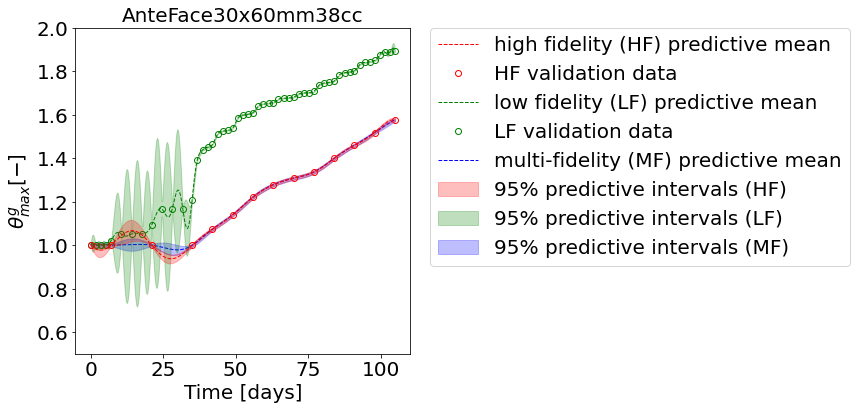

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(Xtest[:,-1], mu3, 'r--', label='high fidelity (HF) predictive mean', linewidth = 1,zorder=3)
ax.fill_between(Xtest[:,-1].flatten(), (mu3 + 2.0*np.sqrt(var3)).flatten(), (mu3 - 2.0*np.sqrt(var3)).flatten(), alpha=0.25, color='r',label='95% predictive intervals (HF)',zorder=3)
ax.plot(tpts_HF, val_high_Y,'ro',fillstyle='none',label='HF validation data',zorder=3)
ax.plot(Xtest[:,-1], mu4,'g--',label='low fidelity (LF) predictive mean', linewidth = 1,zorder=2)
ax.fill_between(Xtest[:,-1].flatten(), (mu4 + 2.0*np.sqrt(var4)).flatten(), (mu4 - 2.0*np.sqrt(var4)).flatten(), alpha=0.25, color='g',label='95% predictive intervals (LF)',zorder=2)
ax.plot(tpts_LF, val_low_Y,'go',fillstyle='none',label='LF validation data',zorder=2)
ax.plot(Xtest[:,-1], mean, 'b--', label='multi-fidelity (MF) predictive mean', linewidth = 1,zorder=1)
ax.fill_between(Xtest[:,-1].flatten(), (mean + 2.0*np.sqrt(var)).flatten(), (mean - 2.0*np.sqrt(var)).flatten(), alpha=0.25, color='b',label='95% predictive intervals (MF)',zorder=1)

ax.set_ylim([0.5,2.0])
ax.legend(frameon=True,bbox_to_anchor=(1.03,1.03),fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('Time [days]',fontsize=20)
ax.set_ylabel(r'$\theta^g_{max} [-]$',fontsize=20)
ax.set_title('%s'%protocol,fontsize=20)